# Elo Merchant Category Recommendation - LightGBM
End date: _2019. february 19._<br/>

This tutorial notebook is the second part of a seriers for [Elo Mechant Category Recommendation](https://www.kaggle.com/c/elo-merchant-category-recommendation) contest organized by Elo, one of the largest payment brands in Brazil. It has built partnerships with merchants in order to offer promotions or discounts to cardholders. The objective of the competition is to identify and serve the most relevant opportunities to individuals, by uncovering signals in customer loyalty. The input files are available from the [download](https://www.kaggle.com/c/elo-merchant-category-recommendation/data) section of the contest:

- **train.csv**,  **test.csv**: list of `card_ids` that can be used for training and testing
- **historical_transactions.csv**: contains up to 3 months' worth of transactions for every card at any of the provided `merchant_ids`
- **new_merchant_transactions.csv**: contains the transactions at new merchants (`merchant_ids` that this particular `card_id` 
has not yet visited) over a period of two months
- **merchants.csv**: contains aggregate information for each `merchant_id` represented in the data set

In [1]:
import os
import gc
import math
import random
import warnings
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

warnings.filterwarnings("ignore")

random.seed(1)
threshold = 0.5

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Starting memory usage: {:5.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min >= np.iinfo(np.int64).min and c_max <= np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Reduced memory usage: {:5.2f} MB ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
def create_date_features(df, source_column, preposition):
    df[preposition + '_year'] = df[source_column].dt.year
    df[preposition + '_month'] = df[source_column].dt.month
    df[preposition + '_day'] = df[source_column].dt.day
    df[preposition + '_hour'] = df[source_column].dt.hour
    df[preposition + '_weekofyear'] = df[source_column].dt.weekofyear
    df[preposition + '_dayofweek'] = df[source_column].dt.dayofweek
    df[preposition + '_quarter'] = df[source_column].dt.quarter
    
    return df

## Merchants

In [4]:
df_merch = pd.read_csv("input/merchants.csv", index_col="merchant_id")
print("{:,} records and {} features in merchant set.".format(df_merch.shape[0], df_merch.shape[1]))

334,696 records and 21 features in merchant set.


In [5]:
df_merch[:3]

,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
merchant_id,,,,,,,,,,,,,,,,,,,,,
M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,9.666667,...,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,1.750000,...,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0
M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,260.000000,...,-82.13,260.000000,2,-82.13,260.000000,2,N,-1,5,5.0


In [6]:
df_merch['category_1'] = df_merch['category_1'].map({'N': 0, 'Y': 1})
df_merch['category_2'] = pd.to_numeric(df_merch['category_2'])
df_merch['category_4'] = df_merch['category_4'].map({'N': 0, 'Y': 1})
df_merch['most_recent_sales_range'] = df_merch['most_recent_sales_range'].map({'E': 0, 'D': 1, 'C': 2, 'B': 3, 'A': 4})
df_merch['most_recent_purchases_range'] = df_merch['most_recent_purchases_range'].map({'E': 0, 'D': 1, 'C': 2, 'B': 3, 'A': 4})

In [7]:
df_merch[['category_1', 'category_2', 'category_4', 'most_recent_sales_range', 'most_recent_purchases_range']][:3]

,category_1,category_2,category_4,most_recent_sales_range,most_recent_purchases_range
merchant_id,,,,,
M_ID_838061e48c,0,1.0,0,0,0
M_ID_9339d880ad,0,1.0,0,0,0
M_ID_e726bbae1e,0,5.0,0,0,0


In [8]:
df_merch = reduce_mem_usage(df_merch)

Starting memory usage: 56.18 MB
Reduced memory usage: 21.39 MB (61.9% reduction)


In [9]:
df_merch = df_merch.groupby(df_merch.index).first()

## Train and test data

In [10]:
df_train = pd.read_csv("input/train.csv")
df_train = reduce_mem_usage(df_train)

df_test = pd.read_csv("input/test.csv")
df_test = reduce_mem_usage(df_test)

print("{:,} records and {} features in train set.".format(df_train.shape[0], df_train.shape[1]))
print("{:,} records and {} features in test set.".format(df_test.shape[0], df_test.shape[1]))

Starting memory usage:  9.24 MB
Reduced memory usage:  4.04 MB (56.2% reduction)
Starting memory usage:  4.72 MB
Reduced memory usage:  2.24 MB (52.5% reduction)
201,917 records and 6 features in train set.
123,623 records and 5 features in test set.


In [11]:
df_train[:3]

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820312
1,2017-01,C_ID_3d0044924f,4,1,0,0.392822
2,2016-08,C_ID_d639edf6cd,2,2,0,0.687988


In [12]:
df_train["year"] = df_train["first_active_month"].str.slice(0, 4)
df_train["year"] = df_train["year"].astype(int)
df_train["month"] = df_train["first_active_month"].str.slice(5, 7)
df_train["month"] = df_train["month"].astype(int)

In [13]:
df_test["year"] = df_test["first_active_month"].str.slice(0, 4)
df_test["year"] = df_test[df_test['first_active_month'].isnull() == False]["year"].astype('int8')
df_test["month"] = df_test["first_active_month"].str.slice(5, 7)
df_test["month"] = df_test[df_test['first_active_month'].isnull() == False]["month"].astype('int8')

In [14]:
df_train[:3]

,first_active_month,card_id,feature_1,feature_2,feature_3,target,year,month
0,2017-06,C_ID_92a2005557,5,2,1,-0.820312,2017,6
1,2017-01,C_ID_3d0044924f,4,1,0,0.392822,2017,1
2,2016-08,C_ID_d639edf6cd,2,2,0,0.687988,2016,8


In [15]:
df_test[:3]

,first_active_month,card_id,feature_1,feature_2,feature_3,year,month
0,2017-04,C_ID_0ab67a22ab,3,3,1,-31.0,4.0
1,2017-01,C_ID_130fd0cbdd,2,3,0,-31.0,1.0
2,2017-08,C_ID_b709037bc5,5,1,1,-31.0,8.0


## Transactions

In [16]:
%%time
df_new_trans = pd.read_csv("input/new_merchant_transactions.csv", index_col='card_id')
df_new_trans = reduce_mem_usage(df_new_trans)

Starting memory usage: 209.67 MB
Reduced memory usage: 114.20 MB (45.5% reduction)
CPU times: user 4.3 s, sys: 1.09 s, total: 5.39 s
Wall time: 5.39 s


In [17]:
%%time
df_hist_trans = pd.read_csv("input/historical_transactions.csv", index_col='card_id')
df_hist_trans = reduce_mem_usage(df_hist_trans)

Starting memory usage: 3109.54 MB
Reduced memory usage: 1749.11 MB (43.8% reduction)
CPU times: user 1min 3s, sys: 57.1 s, total: 2min
Wall time: 2min 56s


In [18]:
df_new_trans['authorized_flag'] = df_new_trans['authorized_flag'].map({'Y': 1, 'N': 0})
df_new_trans['category_1'] = df_new_trans['category_1'].map({'Y': 1, 'N': 0})
df_new_trans['category_3'] = df_new_trans['category_3'].map({'C': 0, 'B': 1, 'A': 2})

df_new_trans['purchase_date'] = pd.to_datetime(df_new_trans['purchase_date'])
df_new_trans = create_date_features(df_new_trans, 'purchase_date', 'purchase')

In [19]:
df_hist_trans['authorized_flag'] = df_hist_trans['authorized_flag'].map({'Y': 1, 'N': 0})
df_hist_trans['category_1'] = df_hist_trans['category_1'].map({'Y': 1, 'N': 0})
df_hist_trans['category_3'] = df_hist_trans['category_3'].map({'C': 0, 'B': 1, 'A': 2})

df_hist_trans['purchase_date'] = pd.to_datetime(df_hist_trans['purchase_date'])
df_hist_trans = create_date_features(df_hist_trans, 'purchase_date', 'purchase')

In [20]:
df_new_trans[:3]

,authorized_flag,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,purchase_year,purchase_month,purchase_day,purchase_hour,purchase_weekofyear,purchase_dayofweek,purchase_quarter
card_id,,,,,,,,,,,,,,,,,,,,
C_ID_415bb3a509,1,107,0,1,1.0,307,M_ID_b0c793002c,1,-0.557617,2018-03-11 14:57:36,1.0,9,19,2018,3,11,14,10,6,1
C_ID_415bb3a509,1,140,0,1,1.0,307,M_ID_88920c89e8,1,-0.569336,2018-03-19 18:53:37,1.0,9,19,2018,3,19,18,12,0,1
C_ID_415bb3a509,1,330,0,1,1.0,507,M_ID_ad5237ef6b,2,-0.551270,2018-04-26 14:08:44,1.0,9,14,2018,4,26,14,17,3,2


In [21]:
df_hist_trans[:3]

,authorized_flag,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,purchase_year,purchase_month,purchase_day,purchase_hour,purchase_weekofyear,purchase_dayofweek,purchase_quarter
card_id,,,,,,,,,,,,,,,,,,,,
C_ID_4e6213e9bc,1,88,0,0,2.0,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37,2017,6,25,15,25,6,2
C_ID_4e6213e9bc,1,88,0,0,2.0,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16,2017,7,15,12,28,5,3
C_ID_4e6213e9bc,1,88,0,0,2.0,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37,2017,8,9,22,32,2,3


## Aggregation

In [22]:
def aggregate_transactions(df, prefix):  
    agg_funcs = {
        'authorized_flag': ['sum', 'mean'],

        'category_1': ['sum', 'mean'],
        'category_2': ['sum', 'mean'],
        'category_3': ['sum', 'mean'],

        'city_id': ['nunique'],

        'installments': ['sum', 'median', 'mean', 'max', 'min', 'std'],

        'merchant_id': ['nunique'],
        'merchant_category_id': ['nunique'],
        'month_lag': ['min', 'max', 'mean'],

        'state_id': ['nunique'],
        'subsector_id': ['nunique'],

        'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
        'purchase_year': ['mean', 'median', 'max', 'min', 'std'],
        'purchase_month': ['mean', 'median', 'max', 'min', 'std'],
        'purchase_day': ['mean', 'median', 'max', 'min', 'std'],
        'purchase_hour': ['mean', 'median', 'max', 'min', 'std'],
        'purchase_weekofyear': ['mean', 'median', 'max', 'min', 'std'],
        'purchase_dayofweek': ['mean', 'median', 'max', 'min', 'std']
    }
    df_agg = df.groupby('card_id').agg(agg_funcs)
    df_agg.columns = [prefix + '_'.join(col).strip() for col in df_agg.columns.values]
    df_agg.reset_index(inplace=True)

    df = (df_agg.groupby('card_id').size().reset_index(name='{}transactions_count'.format(prefix)))
    df_agg = pd.merge(df, df_agg, on='card_id', how='left')

    return df_agg

In [23]:
df_new_trans = aggregate_transactions(df_new_trans, prefix='new_')

In [24]:
df_new_trans = reduce_mem_usage(df_new_trans)

Starting memory usage: 112.29 MB
Reduced memory usage: 30.42 MB (72.9% reduction)


In [25]:
df_new_trans.to_csv('input/trans_new_aggregated.csv')

In [26]:
df_hist_trans = aggregate_transactions(df_hist_trans, prefix='hist_')

In [27]:
df_hist_trans = reduce_mem_usage(df_hist_trans)

Starting memory usage: 129.15 MB
Reduced memory usage: 37.88 MB (70.7% reduction)


In [28]:
df_hist_trans.to_csv('input/trans_hist_aggregated.csv')

## Merging

In [ ]:
df_hist_trans = pd.read_csv("input/trans_hist_aggregated.csv")
df_hist_trans = reduce_mem_usage(df_hist_trans)

In [ ]:
df_new_trans = pd.read_csv("input/trans_new_aggregated.csv")
df_new_trans = reduce_mem_usage(df_new_trans)

Join the data of the merchants and the transactions to the training and test set.

In [29]:
%%time
df_train = pd.merge(df_train, df_hist_trans, on='card_id', how='left')
df_train = pd.merge(df_train, df_new_trans, on='card_id', how='left')

CPU times: user 1.58 s, sys: 156 ms, total: 1.73 s
Wall time: 1.93 s


In [30]:
%%time
df_test = pd.merge(df_test, df_hist_trans, on='card_id', how='left')
df_test = pd.merge(df_test, df_new_trans, on='card_id', how='left')

CPU times: user 1.12 s, sys: 15.6 ms, total: 1.14 s
Wall time: 1.17 s


In [31]:
del df_hist_trans
del df_new_trans
gc.collect()

70

In [32]:
df_train[:3]

,first_active_month,card_id,feature_1,feature_2,feature_3,target,year,month,hist_transactions_count,hist_authorized_flag_sum,...,new_purchase_weekofyear_mean,new_purchase_weekofyear_median,new_purchase_weekofyear_max,new_purchase_weekofyear_min,new_purchase_weekofyear_std,new_purchase_dayofweek_mean,new_purchase_dayofweek_median,new_purchase_dayofweek_max,new_purchase_dayofweek_min,new_purchase_dayofweek_std
0,2017-06,C_ID_92a2005557,5,2,1,-0.820312,2017,6,1,247,...,13.304688,13.0,17.0,10.0,2.304688,3.130859,4.0,6.0,0.0,2.029297
1,2017-01,C_ID_3d0044924f,4,1,0,0.392822,2017,1,1,339,...,9.000000,9.0,13.0,5.0,3.687500,1.500000,1.0,4.0,0.0,1.643555
2,2016-08,C_ID_d639edf6cd,2,2,0,0.687988,2016,8,1,41,...,17.000000,17.0,17.0,17.0,NaN,5.000000,5.0,5.0,5.0,NaN


In [33]:
df_test[:3]

,first_active_month,card_id,feature_1,feature_2,feature_3,year,month,hist_transactions_count,hist_authorized_flag_sum,hist_authorized_flag_mean,...,new_purchase_weekofyear_mean,new_purchase_weekofyear_median,new_purchase_weekofyear_max,new_purchase_weekofyear_min,new_purchase_weekofyear_std,new_purchase_dayofweek_mean,new_purchase_dayofweek_median,new_purchase_dayofweek_max,new_purchase_dayofweek_min,new_purchase_dayofweek_std
0,2017-04,C_ID_0ab67a22ab,3,3,1,-31.0,4.0,1,44,0.646973,...,7.000000,7.0,9.0,5.0,2.000000,3.666016,4.0,5.0,2.0,1.527344
1,2017-01,C_ID_130fd0cbdd,2,3,0,-31.0,1.0,1,77,0.987305,...,12.445312,11.0,16.0,9.0,2.789062,3.000000,4.0,6.0,0.0,2.291016
2,2017-08,C_ID_b709037bc5,5,1,1,-31.0,8.0,1,9,0.692383,...,10.000000,10.0,11.0,9.0,1.414062,2.000000,2.0,3.0,1.0,1.414062


## Training

### LightGBM - all features
For more details click [here](https://lightgbm.readthedocs.io/en/latest/).

In [34]:
target = df_train['target']
drops = ['card_id', 'first_active_month', 'target']
use_cols = [c for c in df_train.columns if c not in drops]
features = list(df_train[use_cols].columns)
df_train[features][:3]

,feature_1,feature_2,feature_3,year,month,hist_transactions_count,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_category_1_sum,hist_category_1_mean,...,new_purchase_weekofyear_mean,new_purchase_weekofyear_median,new_purchase_weekofyear_max,new_purchase_weekofyear_min,new_purchase_weekofyear_std,new_purchase_dayofweek_mean,new_purchase_dayofweek_median,new_purchase_dayofweek_max,new_purchase_dayofweek_min,new_purchase_dayofweek_std
0,5,2,1,2017,6,1,247,0.950195,0,0.000000,...,13.304688,13.0,17.0,10.0,2.304688,3.130859,4.0,6.0,0.0,2.029297
1,4,1,0,2017,1,1,339,0.968750,31,0.088562,...,9.000000,9.0,13.0,5.0,3.687500,1.500000,1.0,4.0,0.0,1.643555
2,2,2,0,2016,8,1,41,0.953613,0,0.000000,...,17.000000,17.0,17.0,17.0,NaN,5.000000,5.0,5.0,5.0,NaN


In [35]:
param = {
    "bagging_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_seed": 11,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "lambda_l1": 0.1,
    'learning_rate': 0.005,
    'max_depth': -1,
    "metric": 'rmse',
    'min_data_in_leaf': 30, 
    'num_leaves': 50,
    'objective':'regression',
    "verbosity": -1
}

folds = KFold(n_splits=5, shuffle=True, random_state=15)

oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))

feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train.values, target.values)):
    print('-')
    print("Fold {}.".format(fold_ + 1))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(df_train.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds=100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    predictions += clf.predict(df_test[features], num_iteration=clf.best_iteration) / folds.n_splits

-
Fold 1
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.71656	valid_1's rmse: 3.79263
[200]	training's rmse: 3.63939	valid_1's rmse: 3.75164
[300]	training's rmse: 3.58604	valid_1's rmse: 3.73019
[400]	training's rmse: 3.54499	valid_1's rmse: 3.71773
[500]	training's rmse: 3.50977	valid_1's rmse: 3.71053
[600]	training's rmse: 3.47933	valid_1's rmse: 3.70562
[700]	training's rmse: 3.45303	valid_1's rmse: 3.70175
[800]	training's rmse: 3.43011	valid_1's rmse: 3.69898
[900]	training's rmse: 3.40965	valid_1's rmse: 3.69689
[1000]	training's rmse: 3.39011	valid_1's rmse: 3.69532
[1100]	training's rmse: 3.37205	valid_1's rmse: 3.69427
[1200]	training's rmse: 3.35507	valid_1's rmse: 3.69319
[1300]	training's rmse: 3.33896	valid_1's rmse: 3.69253
[1400]	training's rmse: 3.32355	valid_1's rmse: 3.69198
[1500]	training's rmse: 3.30886	valid_1's rmse: 3.69166
[1600]	training's rmse: 3.29536	valid_1's rmse: 3.69143
[1700]	training's rmse: 3.28096	valid_1's

In [36]:
cross_validation_lgb = np.sqrt(mean_squared_error(target, oof))
print('Cross-validation score: ' + str(cross_validation_lgb))

Cross-validation score: 3.6702390660342723


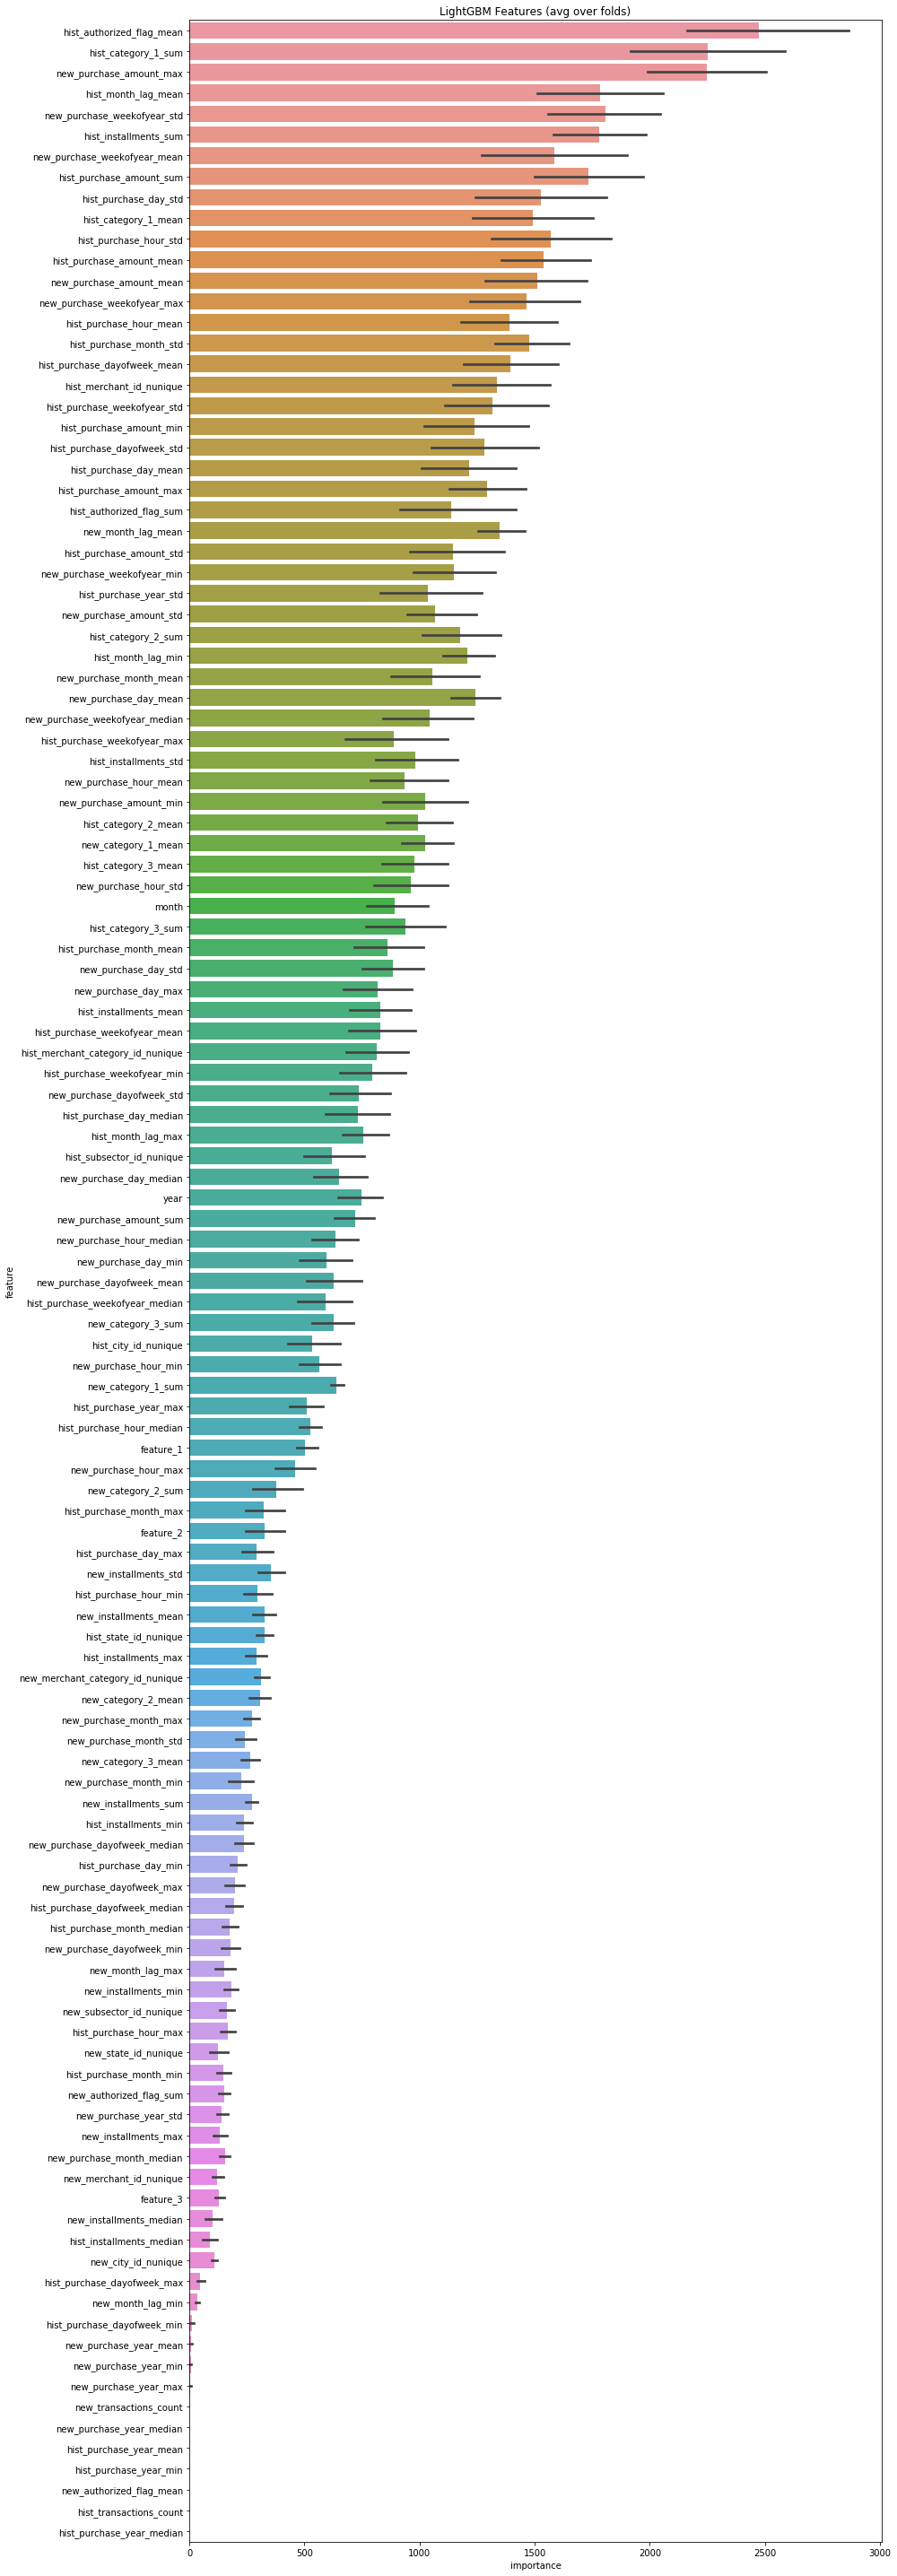

In [37]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df['feature'].isin(cols)]

plt.figure(figsize=(14, 40))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [38]:
clf.save_model('models/lightgbm_all.txt')

In [ ]:
df_sub = pd.DataFrame({"card_id":df_test["card_id"].values})
df_sub["target"] = predictions
df_sub.to_csv("output/lgbm_{}.csv".format(cross_validation_lgb), index=False)

### LightGBM - importance more than 100

In [ ]:
list(best_features[best_features['importance'] < 100]['feature'])

In [ ]:
cols = ['Unnamed: 0_x', 'feature_3', 'hist_transactions_count', 'hist_installments_median', 'hist_purchase_year_mean', 'hist_purchase_year_median', 'hist_purchase_year_min', 'hist_purchase_month_min', 'hist_purchase_dayofweek_max', 'hist_purchase_dayofweek_min', 'new_transactions_count', 'new_authorized_flag_sum', 'new_authorized_flag_mean', 'new_category_1_sum', 'new_category_1_mean', 'new_city_id_nunique', 'new_installments_median', 'new_month_lag_min', 'new_purchase_year_mean', 'new_purchase_year_median', 'new_purchase_year_max', 'new_purchase_year_min', 'hist_transactions_count', 'hist_installments_median', 'hist_purchase_year_mean', 'hist_purchase_year_median', 'hist_purchase_year_min', 'hist_purchase_dayofweek_max', 'hist_purchase_dayofweek_min', 'new_transactions_count', 'new_authorized_flag_sum', 'new_authorized_flag_mean', 'new_category_1_sum', 'new_category_1_mean', 'new_month_lag_min', 'new_purchase_year_mean', 'new_purchase_year_median', 'new_purchase_year_max', 'new_purchase_year_min', 'hist_transactions_count', 'hist_purchase_year_mean', 'hist_purchase_year_median', 'hist_purchase_year_min', 'hist_purchase_dayofweek_max', 'hist_purchase_dayofweek_min', 'new_transactions_count', 'new_authorized_flag_sum', 'new_authorized_flag_mean', 'new_category_1_sum', 'new_category_1_mean', 'new_month_lag_min', 'new_purchase_year_mean', 'new_purchase_year_median', 'new_purchase_year_max', 'new_purchase_year_min', 'hist_transactions_count', 'hist_installments_median', 'hist_purchase_year_mean', 'hist_purchase_year_median', 'hist_purchase_year_min', 'hist_purchase_dayofweek_max', 'hist_purchase_dayofweek_min', 'new_transactions_count', 'new_authorized_flag_sum', 'new_authorized_flag_mean', 'new_category_1_sum', 'new_category_1_mean', 'new_installments_median', 'new_month_lag_min', 'new_purchase_year_mean', 'new_purchase_year_median', 'new_purchase_year_max', 'new_purchase_year_min', 'hist_transactions_count', 'hist_installments_median', 'hist_purchase_year_mean', 'hist_purchase_year_median', 'hist_purchase_year_min', 'hist_purchase_dayofweek_max', 'hist_purchase_dayofweek_min', 'new_transactions_count', 'new_authorized_flag_sum', 'new_authorized_flag_mean', 'new_category_1_sum', 'new_category_1_mean', 'new_month_lag_min', 'new_purchase_year_mean', 'new_purchase_year_median', 'new_purchase_year_max', 'new_purchase_year_min']

df_train.drop(columns=cols, inplace=True, axis=1)
df_test.drop(columns=cols, inplace=True, axis=1)

In [ ]:
drops = ['card_id', 'first_active_month', 'target']
use_cols = [c for c in df_train.columns if c not in drops]
features = list(df_train[use_cols].columns)

In [ ]:
param = {
    'num_leaves': 50,
    'min_data_in_leaf': 30, 
    'objective':'regression',
    'max_depth': -1,
    'learning_rate': 0.005,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.9,
    "bagging_seed": 11,
    "metric": 'rmse',
    "lambda_l1": 0.1,
    "verbosity": -1
}

folds = KFold(n_splits=5, shuffle=True, random_state=15)

oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))

feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train.values, target.values)):
    print('-')
    print("Fold {}".format(fold_ + 1))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(df_train.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds=100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    predictions += clf.predict(df_test[features], num_iteration=clf.best_iteration) / folds.n_splits

In [ ]:
cross_validation_lgb = np.sqrt(mean_squared_error(target, oof))
print('Cross-validation score: ' + str(cross_validation_lgb))

In [ ]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df['feature'].isin(cols)]

plt.figure(figsize=(14, 40))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [ ]:
df_sub = pd.DataFrame({"card_id":df_test["card_id"].values})
df_sub["target"] = predictions
df_sub.to_csv("output/lgbm_{}.csv".format(cross_validation_lgb), index=False)

### LightGBM - importance more than 200

In [ ]:
cols = best_features[best_features['importance'] < 200]['feature']

df_train.drop(columns=cols, inplace=True, axis=1)
df_test.drop(columns=cols, inplace=True, axis=1)

In [ ]:
drops = ['card_id', 'first_active_month', 'target']
use_cols = [c for c in df_train.columns if c not in drops]
features = list(df_train[use_cols].columns)

In [ ]:
param = {
    'num_leaves': 50,
    'min_data_in_leaf': 30, 
    'objective':'regression',
    'max_depth': -1,
    'learning_rate': 0.005,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.9,
    "bagging_seed": 11,
    "metric": 'rmse',
    "lambda_l1": 0.1,
    "verbosity": -1
}

folds = KFold(n_splits=5, shuffle=True, random_state=15)

oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))

feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train.values, target.values)):
    print('-')
    print("Fold {}".format(fold_ + 1))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(df_train.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds=100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    predictions += clf.predict(df_test[features], num_iteration=clf.best_iteration) / folds.n_splits

In [ ]:
cross_validation_lgb = np.sqrt(mean_squared_error(target, oof))
print('Cross-validation score: ' + str(cross_validation_lgb))

In [ ]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df['feature'].isin(cols)]

plt.figure(figsize=(14, 40))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [ ]:
df_sub = pd.DataFrame({"card_id":df_test["card_id"].values})
df_sub["target"] = predictions
df_sub.to_csv("output/lgbm_{}.csv".format(cross_validation_lgb), index=False)